# Computer Vision Examples

This notebook shows example of computer vision models and examples of what they can achieve. 

Please note that here **the models used are not recent**, better results can be expected from newer models.

# Libraries and loading

In [1]:
import requests

import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
img_bio = cv2.imread("data/example.jpg", cv2.IMREAD_COLOR)
img_bio = cv2.cvtColor(img_bio, cv2.COLOR_BGR2RGB)

img_river = cv2.imread(
    "data/rivers/train/images/360_F_190182089_kVJgPPov9cI0AJ84CdCVqVxx2a57928j.jpg",
    cv2.IMREAD_COLOR,
)
img_river = cv2.cvtColor(img_river, cv2.COLOR_BGR2RGB)

In [3]:
# show that the image is an array
print(f"Image shape: {img_bio.shape}")
print(f"Image data type: {img_bio.dtype}")
img_bio

Image shape: (646, 970, 3)
Image data type: uint8


array([[[116, 104,  92],
        [116, 104,  92],
        [116, 104,  92],
        ...,
        [ 78,  77,  72],
        [ 81,  80,  75],
        [ 81,  80,  75]],

       [[116, 104,  92],
        [116, 104,  92],
        [116, 104,  92],
        ...,
        [ 77,  82,  76],
        [ 73,  78,  74],
        [ 73,  78,  72]],

       [[116, 104,  92],
        [116, 104,  92],
        [116, 104,  92],
        ...,
        [ 70,  85,  82],
        [ 75,  89,  89],
        [ 75,  90,  87]],

       ...,

       [[ 53,  48,  45],
        [ 53,  48,  45],
        [ 53,  48,  45],
        ...,
        [ 25,   7,   7],
        [ 28,  10,   8],
        [ 29,  11,   9]],

       [[ 52,  47,  44],
        [ 52,  47,  44],
        [ 53,  48,  45],
        ...,
        [ 24,   6,   6],
        [ 28,  10,   8],
        [ 29,  11,   9]],

       [[ 51,  46,  43],
        [ 52,  47,  44],
        [ 53,  48,  45],
        ...,
        [ 24,   6,   6],
        [ 28,  10,   8],
        [ 29,  11,   9]]

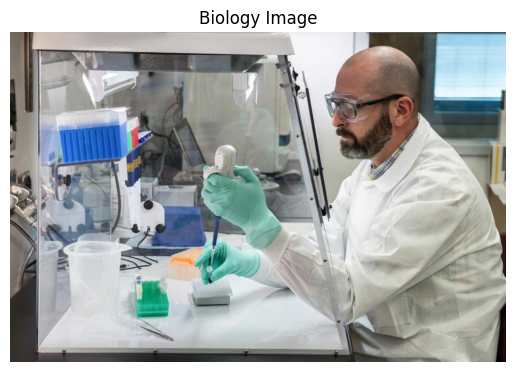

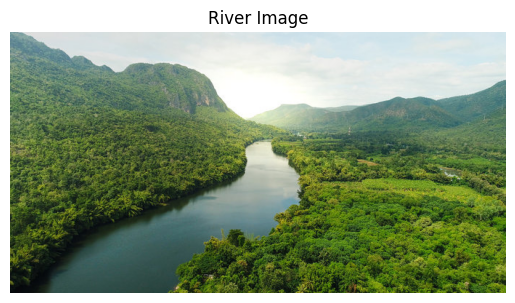

In [4]:
plt.imshow(img_bio)
plt.axis("off")
plt.title("Biology Image")
plt.show()

plt.imshow(img_river)
plt.axis("off")
plt.title("River Image")
plt.show()

# Image Processing

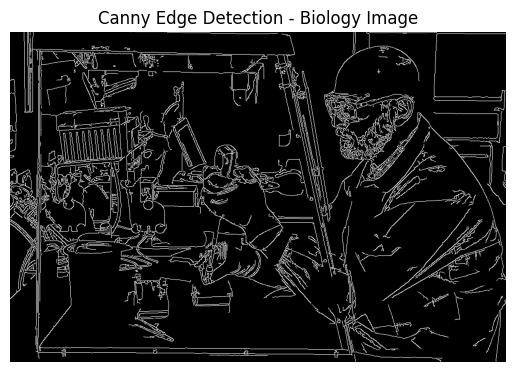

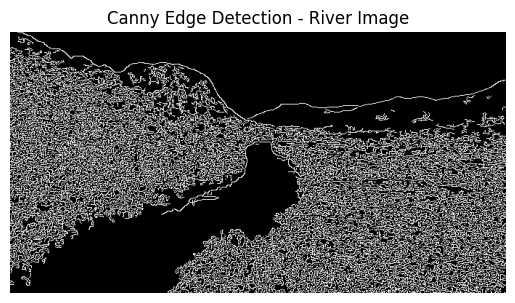

In [5]:
gray_bio = cv2.cvtColor(img_bio, cv2.COLOR_RGB2GRAY)
edges_bio = cv2.Canny(gray_bio, 50, 150)

plt.imshow(edges_bio, cmap="gray")
plt.axis("off")
plt.title("Canny Edge Detection - Biology Image")
plt.show()

gray_river = cv2.cvtColor(img_river, cv2.COLOR_RGB2GRAY)
edges_river = cv2.Canny(gray_river, 50, 150)

plt.imshow(edges_river, cmap="gray")
plt.axis("off")
plt.title("Canny Edge Detection - River Image")
plt.show()

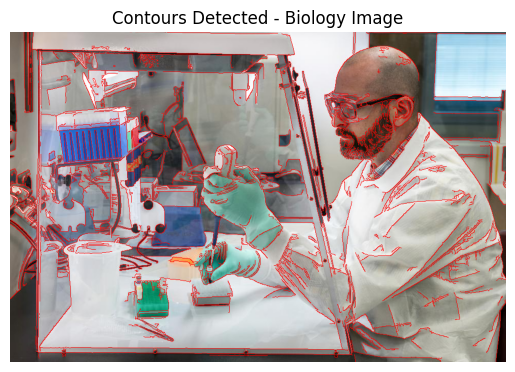

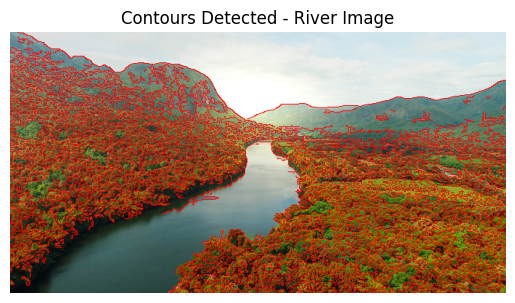

In [6]:
contours_bio, _ = cv2.findContours(
    edges_bio, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
contour_img_bio = img_bio.copy()
cv2.drawContours(contour_img_bio, contours_bio, -1, (255, 0, 0), 1)

plt.imshow(contour_img_bio)
plt.axis("off")
plt.title("Contours Detected - Biology Image")
plt.show()

contours_river, _ = cv2.findContours(
    edges_river, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
contour_img_river = img_river.copy()
cv2.drawContours(contour_img_river, contours_river, -1, (255, 0, 0), 1)

plt.imshow(contour_img_river)
plt.axis("off")
plt.title("Contours Detected - River Image")
plt.show()

# Image Classification

In [7]:
# Get pretrained model
model = torchvision.models.mobilenet_v2(
    weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V1
)
model.eval()

# Preprocess the image
preprocess = T.Compose(
    [
        T.ToPILImage(),
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
bio_tensor = preprocess(img_bio)
river_tensor = preprocess(img_river)
input_batch = torch.stack([bio_tensor, river_tensor])

In [8]:
# Predict
with torch.no_grad():
    outputs = model(input_batch)

labels = torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V1.meta["categories"]

for output in outputs:

    pred_class = labels[output.argmax()]
    pred_proba = torch.nn.functional.softmax(output, dim=0)[output.argmax()]
    print(f"{pred_class} (proba: {pred_proba.item()*100:.2f} %)")

lab coat (proba: 83.22 %)
valley (proba: 96.91 %)


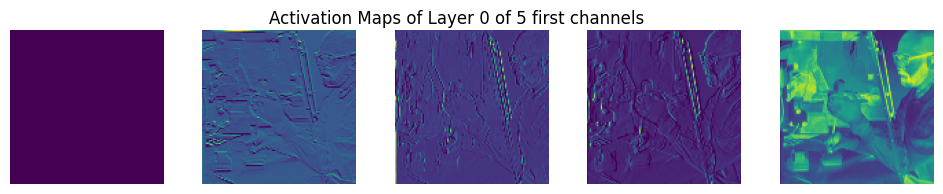

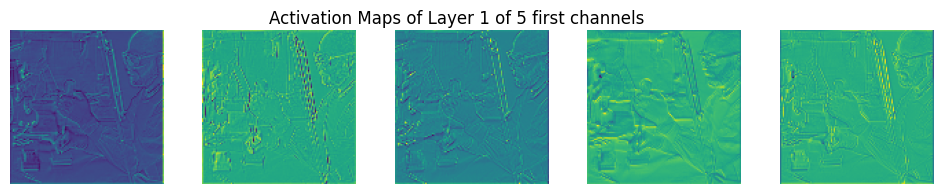

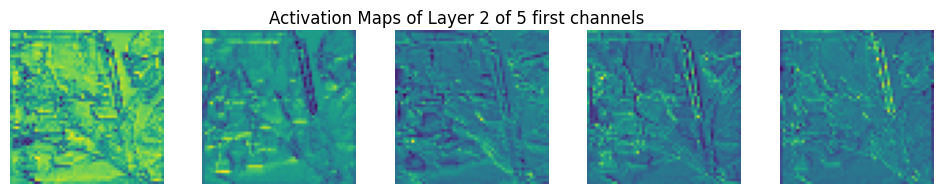

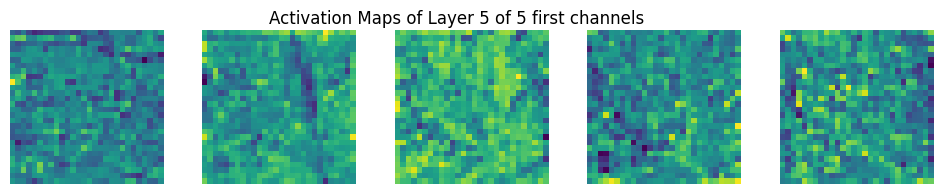

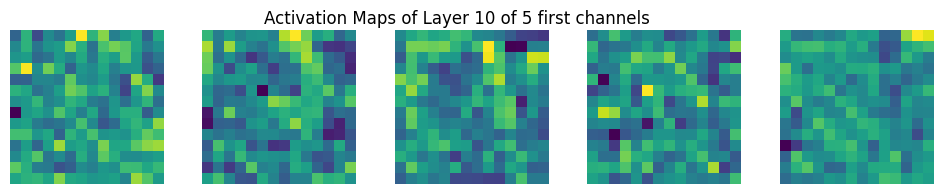

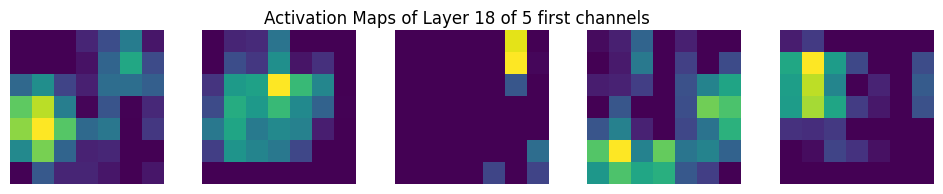

In [9]:
# Show the activation layers of some random convolutional layers
layers_to_visualize = [0, 1, 2, 5, 10, 18]

with torch.no_grad():
    activations = []
    x = input_batch
    for i, layer in enumerate(model.features):
        x = layer(x)
        if i in layers_to_visualize:
            activations.append(x)

for i, act in enumerate(activations):
    act = act[0, :5].cpu()
    fig, axs = plt.subplots(1, 5, figsize=(12, 2))
    fig.suptitle(
        f"Activation Maps of Layer {layers_to_visualize[i]} of 5 first channels"
    )
    for j in range(5):
        axs[j].imshow(act[j], cmap="viridis")
        axs[j].axis("off")
    plt.show()

# Object Detection and Classification

In [10]:
# Get pretrained model
model = fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)
model.eval()

# Prepare image for model (just other format)
transform = T.Compose([T.ToPILImage(), T.ToTensor()])

bio_tensor = transform(img_bio)
river_tensor = transform(img_river)

In [11]:
# Make prediction
predictions = []
with torch.no_grad():
    for img_tensor in [bio_tensor, river_tensor]:
        prediction = model([img_tensor])[0]
        predictions.append(prediction)

coco_labels_url = "https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt"
labels = [line.strip() for line in requests.get(coco_labels_url).text.splitlines()]

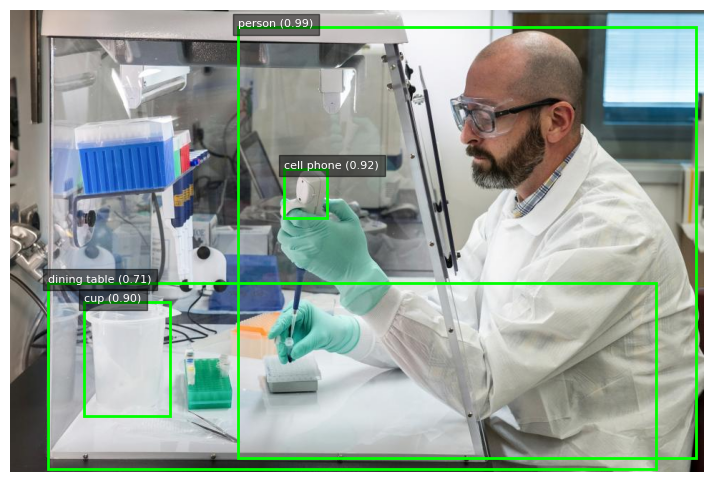

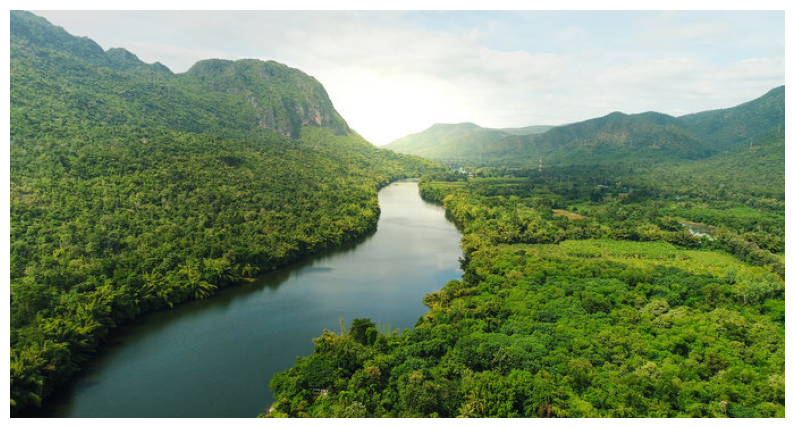

In [12]:
# Visualize results
for image, prediction in zip([img_bio, img_river], predictions):
    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.imshow(image)

    for box, score, label in zip(
        prediction["boxes"], prediction["scores"], prediction["labels"]
    ):
        if score > 0.7:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=2,
                edgecolor="lime",
                facecolor="none",
            )
            ax.add_patch(rect)
            ax.text(
                x1,
                y1,
                f"{labels[label.item()-1]} ({score:.2f})",
                color="white",
                fontsize=8,
                bbox=dict(facecolor="black", alpha=0.5),
            )

    ax.axis("off")
    plt.show()

# Image Segmentation

In [13]:
# Get pretrained model
model = torchvision.models.segmentation.fcn_resnet50(
    weights="FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1"
)
model.eval()

# Prepare image for model
transform = T.Compose([T.ToPILImage(), T.Resize((224, 224)), T.ToTensor()])
bio_tensor = transform(img_bio)
river_tensor = transform(img_river)
img_tensor = torch.stack([bio_tensor, river_tensor])

In [14]:
# Make prediction
predictions = []
with torch.no_grad():
    for img_tensor in [bio_tensor, river_tensor]:
        img_tensor = img_tensor.unsqueeze(0)  # add batch dimension
        prediction = model(img_tensor)["out"][0]  # use 'out' key
        predictions.append(prediction)

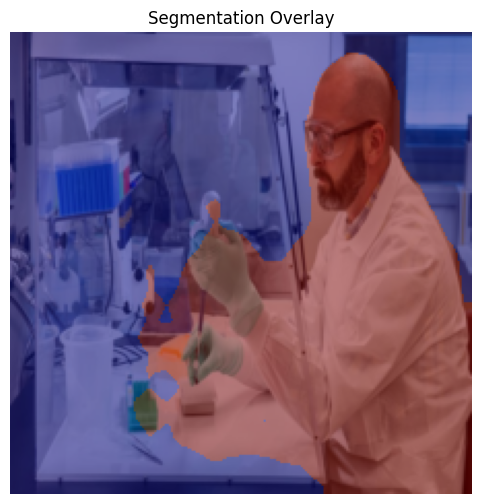

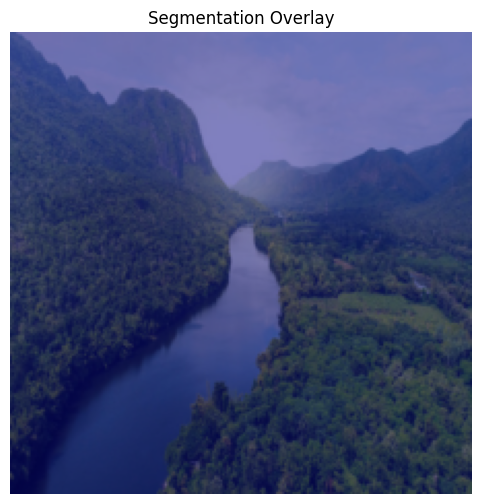

In [15]:
# Visualize results
for image, prediction in zip([img_bio, img_river], predictions):
    pred_classes = prediction.argmax(0).byte().cpu().numpy()
    image_transformed = T.Resize((224, 224))(T.ToPILImage()(image))

    plt.figure(figsize=(10, 6))
    plt.imshow(image_transformed)
    plt.imshow(pred_classes, alpha=0.5, cmap="jet")
    plt.axis("off")
    plt.title("Segmentation Overlay")
    plt.show()

# Fine tuning for image segmentation

In [16]:
# Define image transforms
img_transform = T.Compose([T.Resize((128, 128)), T.ToTensor()])
mask_transform = T.Resize((128, 128))


# Define datasets class to store the images and their segmentation masks
class TinySegDataset(Dataset):
    def __init__(
        self, image_paths, mask_paths, img_transform=None, mask_transform=None
    ):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # single channel

        if self.img_transform:
            img = self.img_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = torch.tensor(np.array(mask) / 255.0, dtype=torch.float32)
        mask = mask.unsqueeze(0)
        return img, mask

In [17]:
# Get path to all images
train_image_paths = [
    os.path.join("data/rivers/train/images", f)
    for f in os.listdir("data/rivers/train/images")
]
train_mask_paths = [
    os.path.join("data/rivers/train/masks", f)
    for f in os.listdir("data/rivers/train/masks")
]
test_image_paths = [
    os.path.join("data/rivers/test/images", f)
    for f in os.listdir("data/rivers/test/images")
]
test_mask_paths = [
    os.path.join("data/rivers/test/masks", f)
    for f in os.listdir("data/rivers/test/masks")
]

# Create datasets and dataloaders
train_dataset = TinySegDataset(
    train_image_paths, train_mask_paths, img_transform, mask_transform
)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

test_dataset = TinySegDataset(
    test_image_paths, test_mask_paths, img_transform, mask_transform
)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

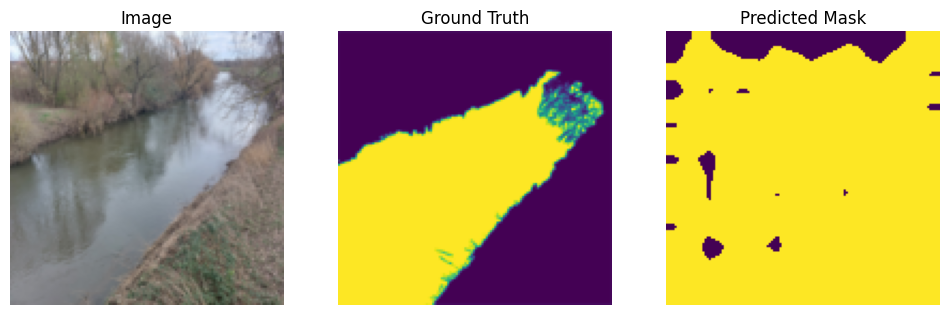

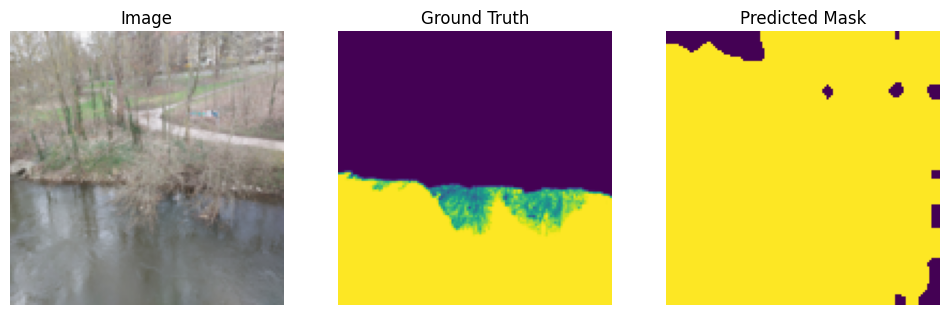

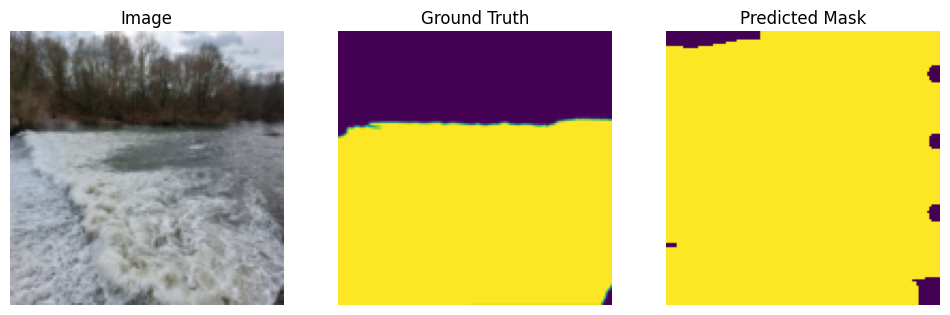

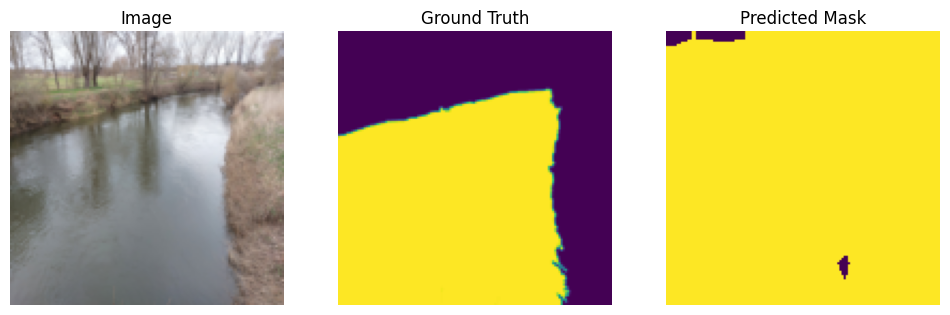

In [18]:
# Show prediction on test set with untrained model
model_raw = torchvision.models.segmentation.fcn_resnet50(weights=None)
model_raw.classifier[4] = nn.Conv2d(512, 1, kernel_size=1)
model_raw.eval()

predictions = []
with torch.no_grad():
    for imgs, masks in test_loader:
        pred = torch.sigmoid(model_raw(imgs)["out"]) > 0.5
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(imgs[0].permute(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(masks[0, 0])
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred[0, 0])
        plt.title("Predicted Mask")
        plt.axis("off")
        plt.show()

In [19]:
# Show prediction on test set with untrained model
model_finetuned = torchvision.models.segmentation.fcn_resnet50(weights=None)
model_finetuned.classifier[4] = nn.Conv2d(512, 1, kernel_size=1)
model_finetuned.train()

optimizer = torch.optim.Adam(model_finetuned.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(5):
    for imgs, masks in train_loader:
        optimizer.zero_grad()
        outputs = model_finetuned(imgs)["out"]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss={loss.item():.4f}")

Epoch 1, Loss=0.2850
Epoch 2, Loss=0.3304
Epoch 3, Loss=0.2958
Epoch 4, Loss=0.3262
Epoch 5, Loss=0.2152


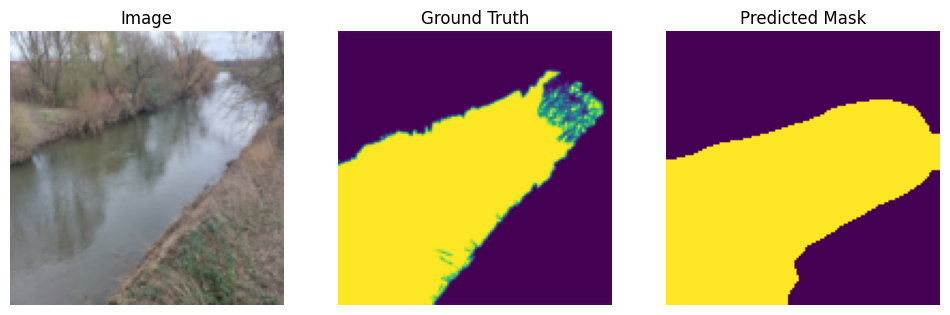

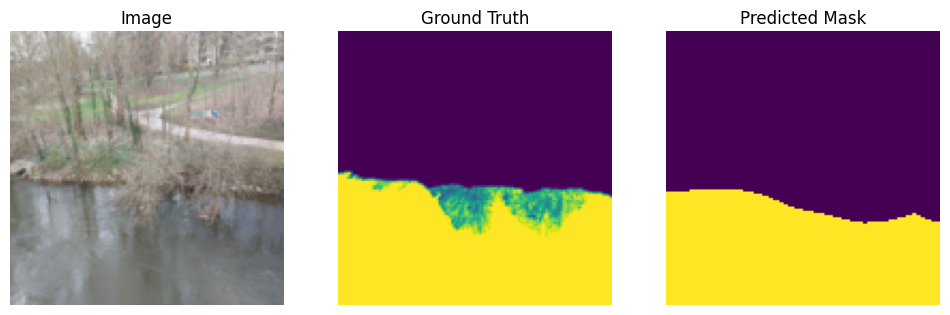

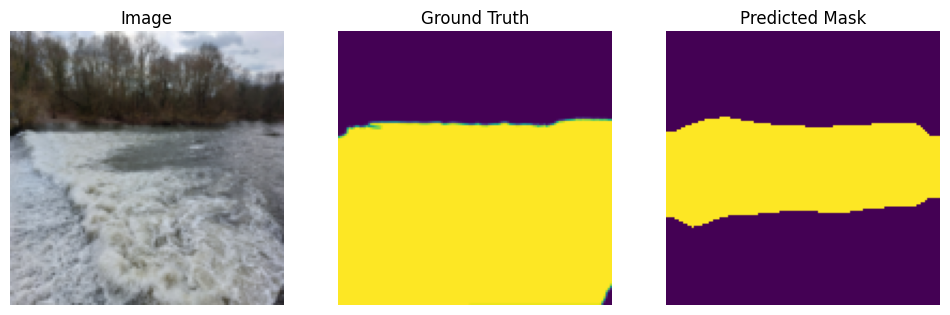

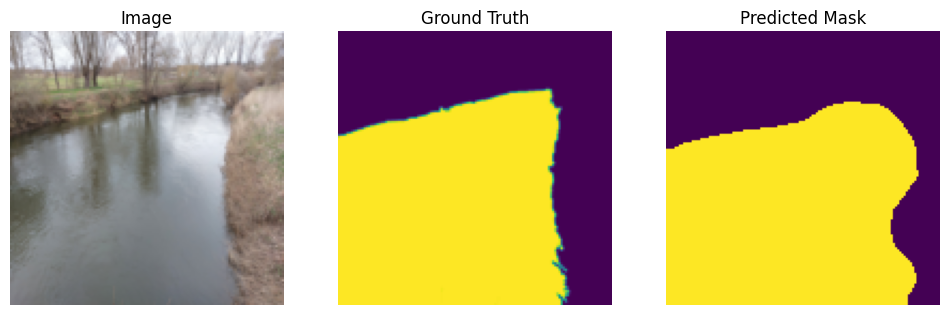

In [20]:
with torch.no_grad():
    for imgs, masks in test_loader:
        pred = torch.sigmoid(model_finetuned(imgs)["out"]) > 0.5
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(imgs[0].permute(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(masks[0, 0])
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred[0, 0])
        plt.title("Predicted Mask")
        plt.axis("off")
        plt.show()

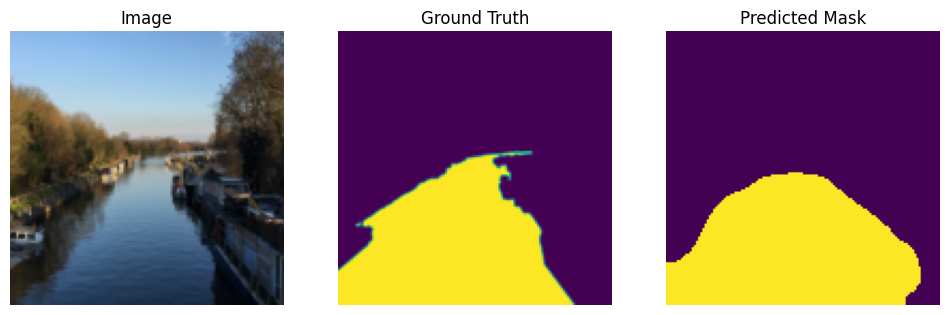

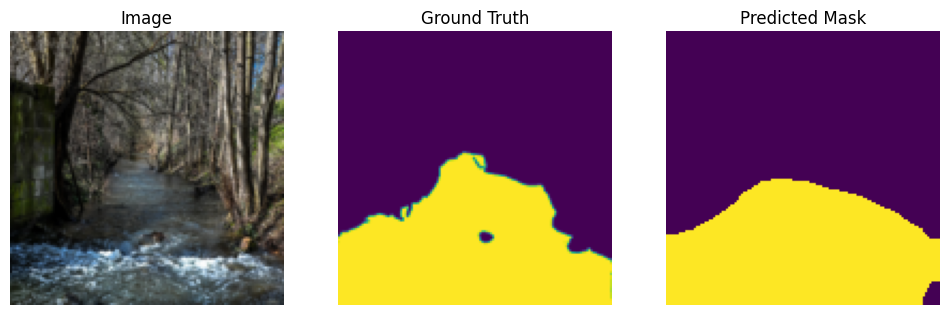

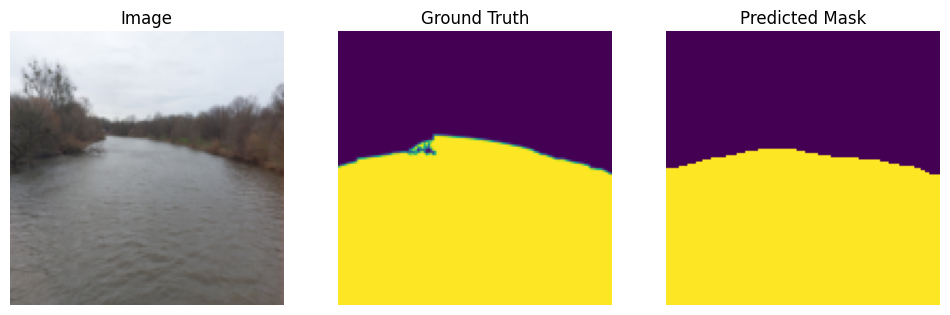

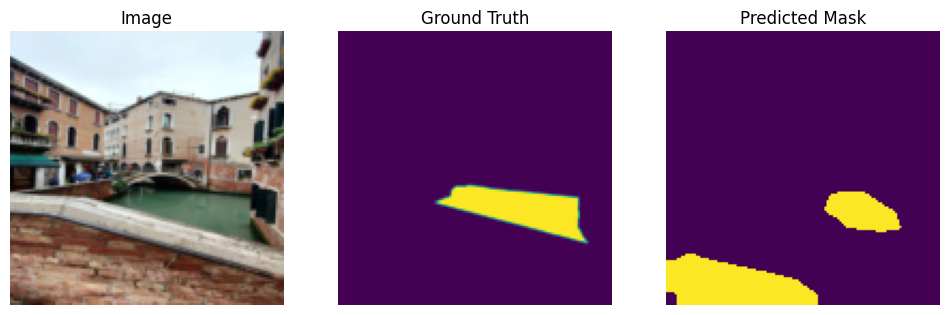

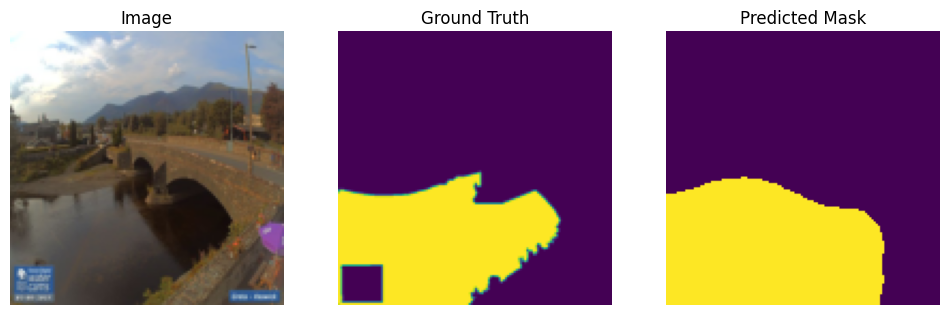

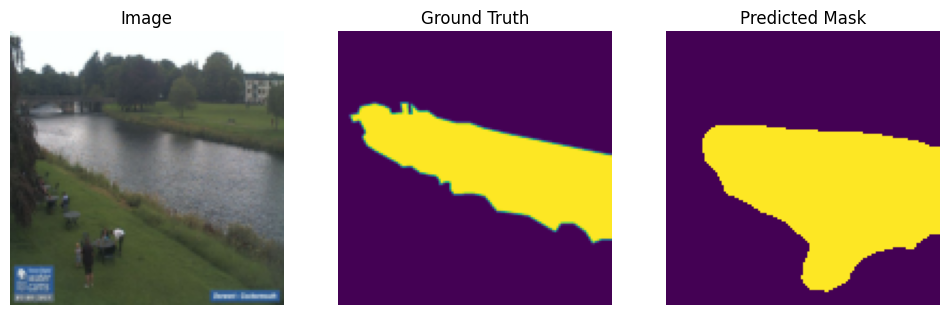

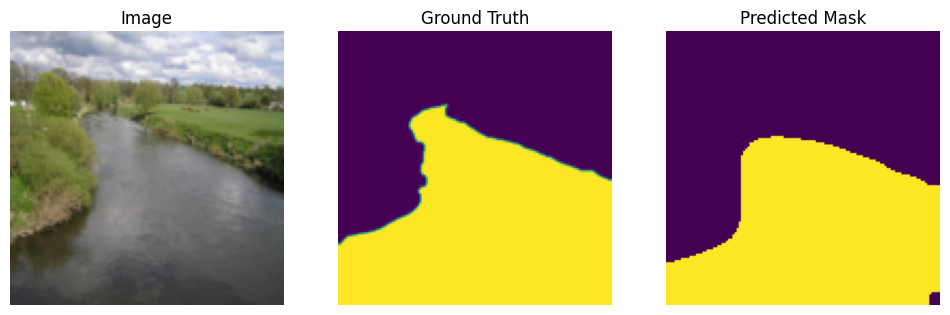

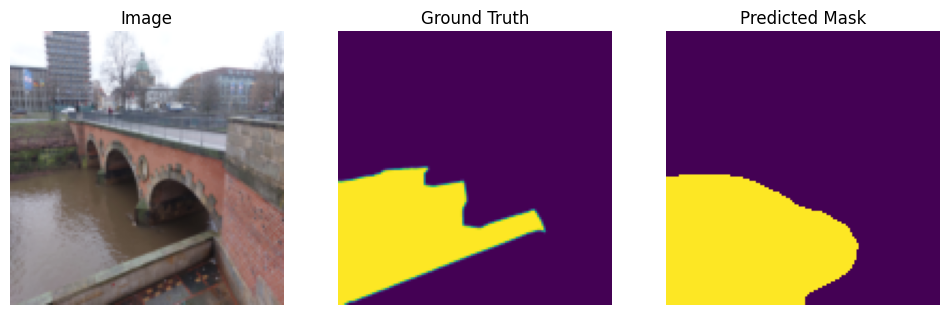

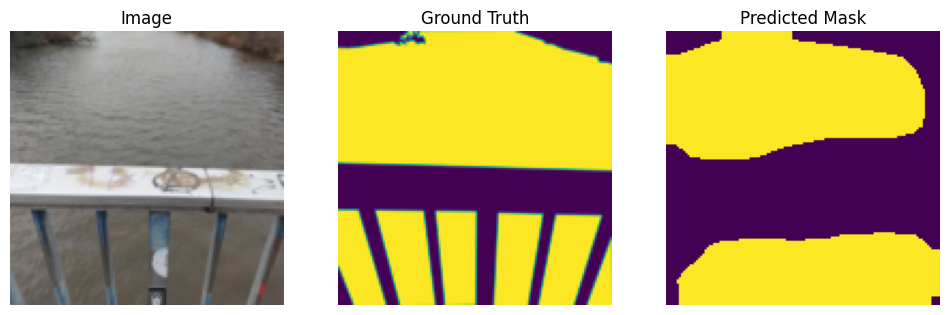

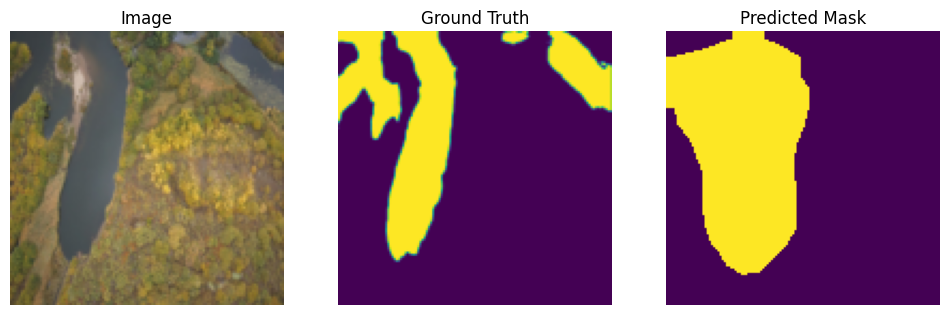

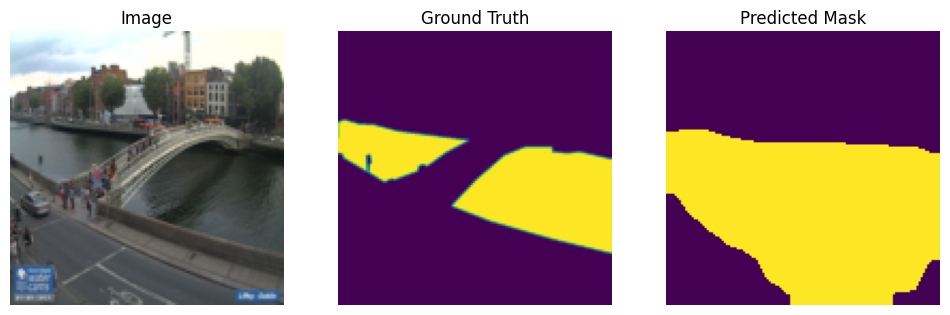

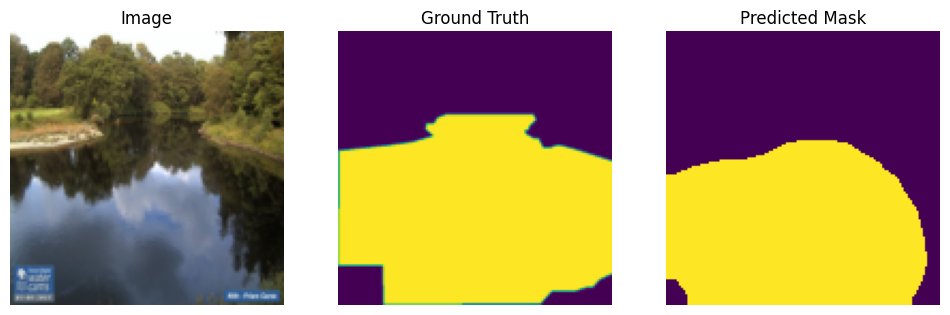

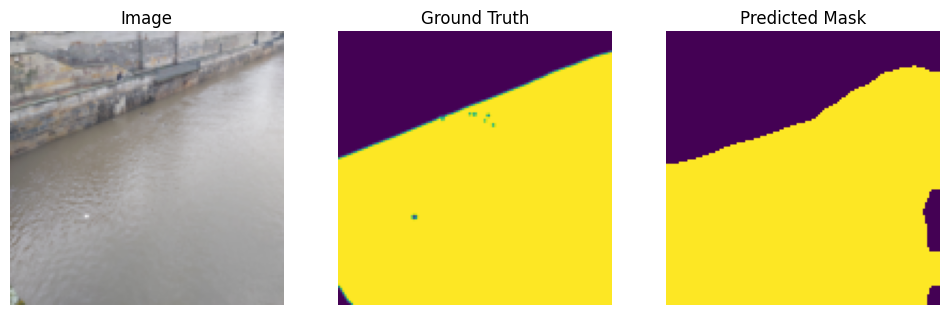

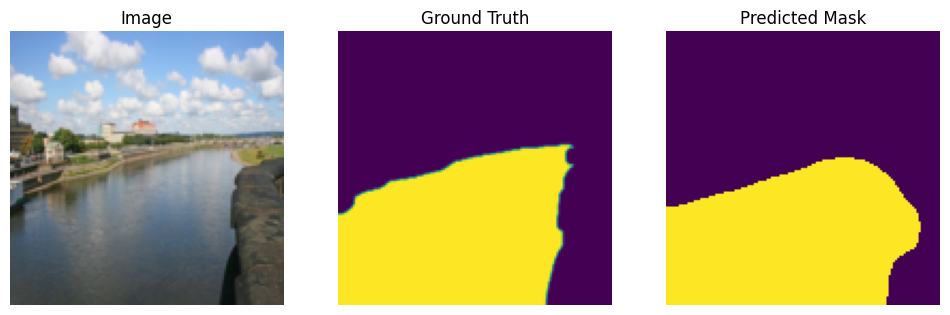

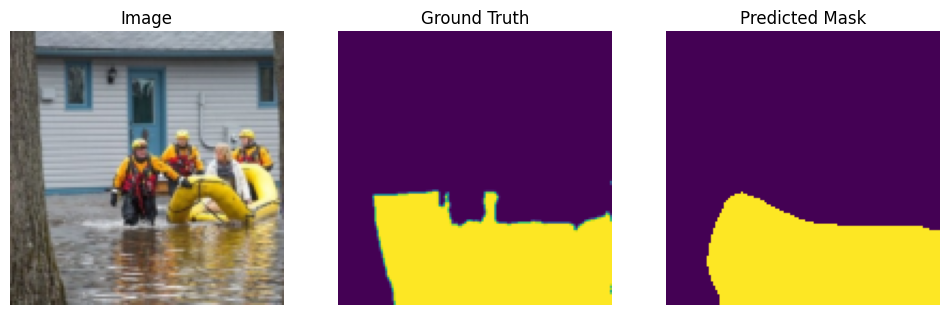

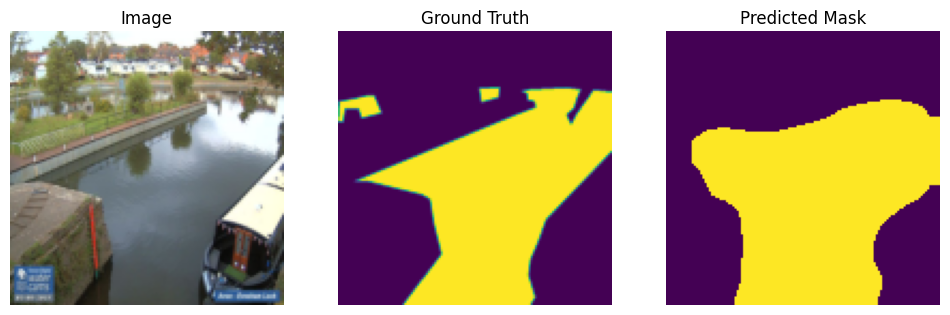

In [21]:
with torch.no_grad():
    for imgs, masks in train_loader:
        pred = torch.sigmoid(model_finetuned(imgs)["out"]) > 0.5
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(imgs[0].permute(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(masks[0, 0])
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred[0, 0])
        plt.title("Predicted Mask")
        plt.axis("off")
        plt.show()

------------